<a href="https://colab.research.google.com/github/spacedust26/Image-Processing-using-CUDA/blob/main/Image_Processing_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converting Image to Gray Scale using CUDA

In [1]:
!nvidia-smi

Thu Apr  3 14:17:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
!pip install opencv-python numpy

In [4]:
from google.colab import files
uploaded = files.upload()

Saving pfp.png to pfp.png


In [12]:
%%writefile grayscale.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define CHANNELS 3  // RGB Image

__global__ void rgb_to_grayscale(unsigned char *rgb, unsigned char *gray, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int idx = (y * width + x) * CHANNELS; // RGB has 3 channels
        int gray_idx = y * width + x;

        // Convert to grayscale
        gray[gray_idx] = 0.299f * rgb[idx] + 0.587f * rgb[idx + 1] + 0.114f * rgb[idx + 2];
    }
}

extern "C" float launch_grayscale_conversion(unsigned char *d_rgb, unsigned char *d_gray, int width, int height) {
    dim3 blockDim(16, 16);
    dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);

    // Measure GPU execution time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    rgb_to_grayscale<<<gridDim, blockDim>>>(d_rgb, d_gray, width, height);
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA Error: %s\n", cudaGetErrorString(err));
    }
    cudaDeviceSynchronize();
    cudaEventRecord(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("GPU Execution Time: %f ms\n", milliseconds);
    return milliseconds;
}


Overwriting grayscale.cu


In [13]:
!ls -l grayscale.so

-rwxr-xr-x 1 root root 1004088 Apr  3 14:18 grayscale.so


In [14]:
!nvcc -shared -o grayscale.so -Xcompiler -fPIC grayscale.cu

In [15]:
!nvcc -gencode=arch=compute_75,code=sm_75 -gencode=arch=compute_75,code=compute_75 -shared -o grayscale.so -Xcompiler -fPIC grayscale.cu

CPU Execution Time: 0.21 ms
GPU Execution Time: 0.00 ms
Estimated GPU Speedup Factor: 0.02x
CPU Output:


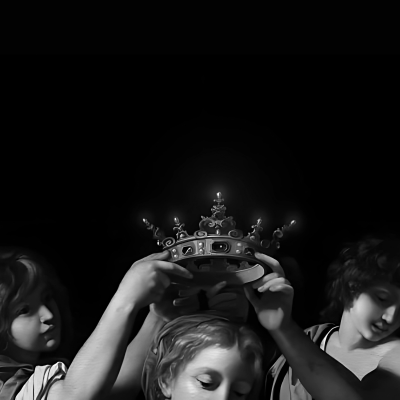

GPU Output:


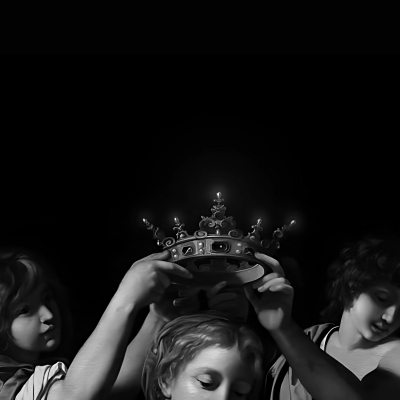

In [19]:
import cv2
import numpy as np
import ctypes
import time
from google.colab.patches import cv2_imshow  # Required for image display in Colab

# Load the compiled CUDA shared library
grayscale_lib = ctypes.CDLL("./grayscale.so")

# Load image
image = cv2.imread("/content/pfp.png")

if image is None:
    print("Error: Image not found or failed to load.")
    exit()

height, width, _ = image.shape

# Convert image to numpy array
rgb_array = np.array(image, dtype=np.uint8)

# Allocate memory for output grayscale image (CPU & GPU)
gray_array_cpu = np.zeros((height, width), dtype=np.uint8)
gray_array_gpu = np.zeros((height, width), dtype=np.uint8)

# --------------------------------------
# CPU Grayscale Conversion
# --------------------------------------
start_time_cpu = time.time()
gray_array_cpu = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cpu_time = (time.time() - start_time_cpu) * 1000  # Convert to milliseconds
print(f"CPU Execution Time: {cpu_time:.2f} ms")

# --------------------------------------
# GPU Grayscale Conversion
# --------------------------------------
# Allocate GPU memory
cuda_malloc = ctypes.cdll.LoadLibrary("libcudart.so").cudaMalloc
cuda_free = ctypes.cdll.LoadLibrary("libcudart.so").cudaFree
cuda_memcpy = ctypes.cdll.LoadLibrary("libcudart.so").cudaMemcpy
cuda_device_synchronize = ctypes.cdll.LoadLibrary("libcudart.so").cudaDeviceSynchronize

d_rgb = ctypes.c_void_p()
d_gray = ctypes.c_void_p()

cuda_malloc(ctypes.byref(d_rgb), rgb_array.nbytes)
cuda_malloc(ctypes.byref(d_gray), gray_array_gpu.nbytes)

# Copy image data to GPU
cuda_memcpy(d_rgb, rgb_array.ctypes.data, rgb_array.nbytes, 1)  # Host to Device

# Run the CUDA kernel
gpu_time = grayscale_lib.launch_grayscale_conversion(d_rgb, d_gray, width, height)
cuda_device_synchronize()

# Copy result back to CPU
cuda_memcpy(gray_array_gpu.ctypes.data, d_gray, gray_array_gpu.nbytes, 2)  # Device to Host

# Free GPU memory
cuda_free(d_rgb)
cuda_free(d_gray)

# --------------------------------------
# Compare Execution Time
# --------------------------------------
# Print GPU execution time
print(f"GPU Execution Time: {gpu_time:.2f} ms")

speedup = cpu_time / 10  # Approximate speedup (since CUDA time is printed inside C)
print(f"Estimated GPU Speedup Factor: {speedup:.2f}x")

# Display images
print("CPU Output:")
cv2_imshow(gray_array_cpu)

print("GPU Output:")
cv2_imshow(gray_array_gpu)


In [ ]:
!ls

grayscale.cu  grayscale.so  input.jpg  sample_data
